<a href="https://colab.research.google.com/github/utkarshsharma1/Rust-Detection-using-Mask-RCNN/blob/master/mrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/matterport/Mask_RCNN
import os 
os.chdir('/content/Mask_RCNN')

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [0]:
!pip install tensorflow-gpu==1.13.1
!pip install q keras==2.1.0
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
from mrcnn import utils
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN

import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import sys
import time
import datetime
import json
import skimage.draw

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from keras.models import load_model

%matplotlib inline

from os import listdir
from xml.etree import ElementTree

1.13.1
2.1.0


In [0]:
class CustomConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "damage"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + rust

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [0]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("damage", 1, "damage")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "v1.json")))
        print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "damage",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "damage":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [0]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom('dataset', "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom('dataset', "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate = config.LEARNING_RATE,
                epochs=5,
                layers='heads')

In [0]:
#This command downloads mask_rcnn_coco.h5 file
sys.path.append('/content/Mask_RCNN/samples/coco')  # To find local version
import coco

# Local path to trained weights file
COCO_MODEL_PATH = "mask_rcnn_coco.h5"

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [0]:
def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    # Copy color pixels from the original color image where mask is set
    if mask.shape[0] > 0:
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray
    return splash

In [0]:
def detect_and_color_splash(model, image_path):

    # Run model detection and generate the color splash effect
    print("Running on {}".format(image_path))
    # Read image
    image = skimage.io.imread(image_path)
    
    # Detect objects
    r = model.detect([image], verbose=1)[0]
    # Color splash
    splash = color_splash(image, r['masks'])
    # Save output
    file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
    skimage.io.imsave(file_name, splash)

    print("Saved to ", file_name)

In [0]:
config = CustomConfig()

In [0]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [0]:
weights_path = COCO_MODEL_PATH
model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

In [0]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
train(model)

{'rust.0.jpg99188': {'fileref': '', 'size': 99188, 'filename': 'rust.0.jpg', 'base64_img_data': '', 'file_attributes': {}, 'regions': {'0': {'shape_attributes': {'name': 'polygon', 'all_points_x': [47, 80, 92, 135, 175, 198, 193, 212, 228, 230, 232, 269, 303, 313, 321, 289, 282, 94, 48, 18, 47], 'all_points_y': [147, 169, 144, 194, 287, 165, 35, 4, 5, 114, 137, 39, 102, 180, 239, 255, 328, 335, 233, 186, 147]}, 'region_attributes': {}}, '1': {'shape_attributes': {'name': 'polygon', 'all_points_x': [356, 376, 426, 465, 416, 359, 315, 340, 388, 375, 356], 'all_points_y': [72, 55, 172, 228, 317, 316, 290, 227, 176, 115, 72]}, 'region_attributes': {}}}}, 'rust.1.jpg78721': {'fileref': '', 'size': 78721, 'filename': 'rust.1.jpg', 'base64_img_data': '', 'file_attributes': {}, 'regions': {'0': {'shape_attributes': {'name': 'polygon', 'all_points_x': [12, 86, 105, 163, 164, 220, 284, 281, 227, 165, 202, 260, 255, 209, 147, 123, 91, 122, 88, 62, 40, 19, 1, 12], 'all_points_y': [28, 36, 0, 6, 63

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/5
 99/100 [============================>.] - ETA: 1s - loss: 1.5272 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.4162 - mrcnn_class_loss: 0.1001 - mrcnn_bbox_loss: 0.5027 - mrcnn_mask_loss: 0.4768

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 177s 2s/step - loss: 1.5185 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.4126 - mrcnn_class_loss: 0.0997 - mrcnn_bbox_loss: 0.4991 - mrcnn_mask_loss: 0.4760 - val_loss: 2.3080 - val_rpn_class_loss: 0.0295 - val_rpn_bbox_loss: 0.2935 - val_mrcnn_class_loss: 0.1753 - val_mrcnn_bbox_loss: 0.9019 - val_mrcnn_mask_loss: 0.9077
Epoch 2/5
100/100 [==============================] - 104s 1s/step - loss: 0.5749 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.1562 - mrcnn_mask_loss: 0.2633 - val_loss: 2.4897 - val_rpn_class_loss: 0.0290 - val_rpn_bbox_loss: 0.3874 - val_mrcnn_class_loss: 0.1784 - val_mrcnn_bbox_loss: 0.7656 - val_mrcnn_mask_loss: 1.1293
Epoch 3/5
100/100 [==============================] - 102s 1s/step - loss: 0.3472 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.0461 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.1638 - val_loss: 3.0472 - val_rpn_class_loss: 0.0307 -

In [0]:
model_path = '/content/Mask_RCNN/my_rust_model_v2.h5'
model.keras_model.save_weights(model_path)

In [0]:
class InferConfig(Config):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
infer_config = InferConfig()

In [0]:
model = modellib.MaskRCNN(mode="inference", model_dir='./', config = config)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [0]:
model.load_weights('my_rust_model_v2.h5', by_name=True)

In [0]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Processing 2 images
image                    shape: (408, 612, 3)         min:    0.00000  max:  255.00000  uint8
image                    shape: (340, 406, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (2, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (2, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (2, 261888, 4)        min:   -0.35390  max:    1.29134  float32

*** No instances to display *** 



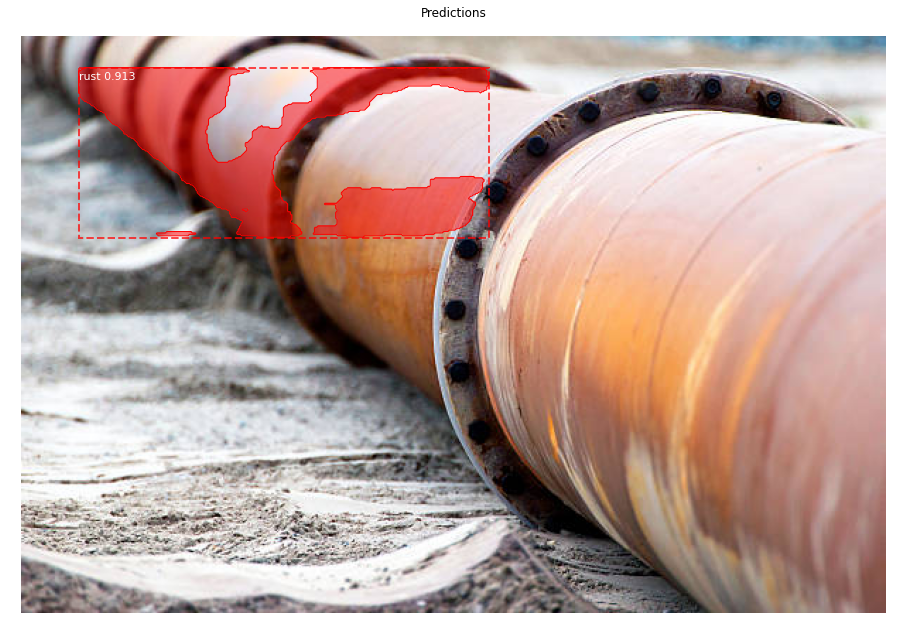

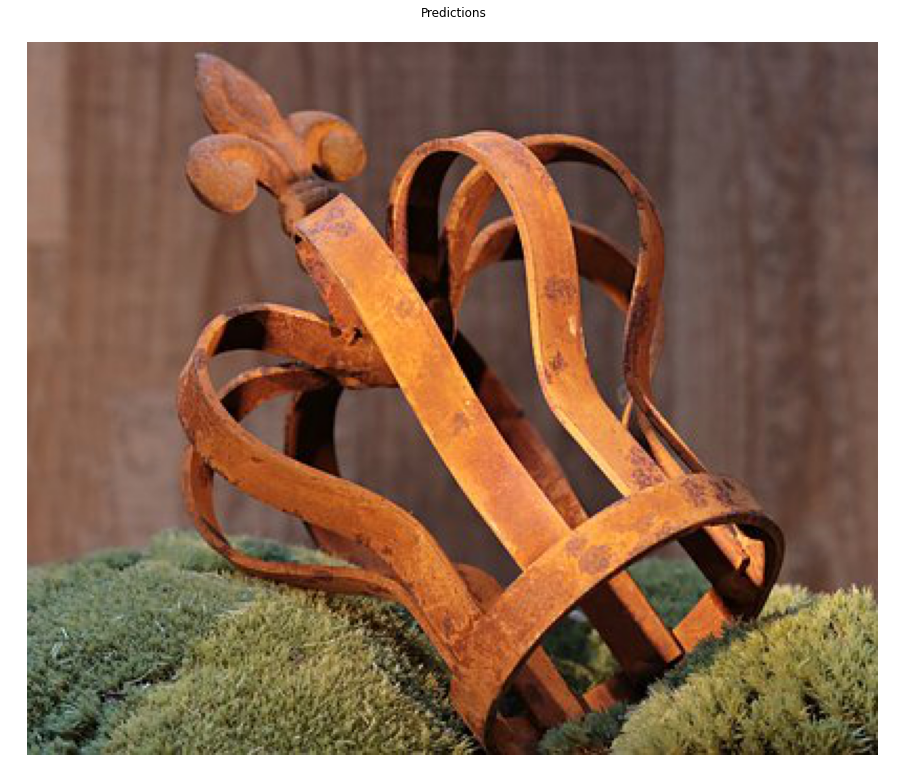

In [0]:
path = '/content/Mask_RCNN/dataset/rust.28.jpg'

image = skimage.io.imread(path)

path = '/content/Mask_RCNN/dataset/rust.30.jpg'

image2 = skimage.io.imread(path)

# Run object detection
results = model.detect([image, image2], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            ['BG', 'rust'], r['scores'], ax=ax,
                            title="Predictions")
ax = get_ax(1)
r = results[1]
visualize.display_instances(image2, r['rois'], r['masks'], r['class_ids'], 
                            ['BG', 'rust'], r['scores'], ax=ax,
                            title="Predictions")


In [0]:
len(results[1])

4